## KNN Lazy learning method

### 1- Loading of data

In [5]:
import pandas as pd
try:
    diabetes_df = pd.read_csv('../preprocessing_scripts/Data_preprocessed_10000.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    diabetes_df = None
    print("File not found. Please check the file path.")

Dataset loaded successfully.


### 2- Visualize first columns

In [6]:
diabetes_df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.0,1.0,1.0,-1.071593,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,10.0,4.0,5.0
1,0.0,0.0,0.0,1.0,0.628607,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,3.0,1.0,0.0,13.0,5.0,4.0
2,0.0,1.0,1.0,1.0,-0.319133,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,5.0,0.0,1.0,8.0,6.0,6.0
3,0.0,0.0,1.0,1.0,0.017644,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,7.0,5.0,8.0
4,1.0,1.0,0.0,1.0,2.311887,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,4.0,30.0,10.0,1.0,1.0,6.0,6.0,3.0


### 3- Separate the features and target variable

In [7]:
# Let's separate Data from labels

X = diabetes_df.drop(['Diabetes_binary'], axis=1) # Data
y = diabetes_df['Diabetes_binary'].astype(int)# Label (Has diabtes (1) or not (0))

print(X.shape)
print(y.shape)

(9939, 21)
(9939,)


### 4 - Normalize data

In [8]:
# Check what is the actual score without any normalize
# We are going to use k-fold cross validation
# We apply to all methods the same random state 42

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import sklearn.neighbors as nb
import numpy as np

# Ensures each fold maintains the same class distribution as the full dataset, 
# which is crucial for imbalanced classification tasks.
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = True) 

# We are going to use the KNeighborsClassifier without any parameter tuning so,
# it will use 5 neighbors by default. Later we will use the GridSearchCV to find the best parameters
# for the KNeighborsClassifier
cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X,y=y, cv=cv, scoring='accuracy')  
np.mean(cv_scores)

np.float64(0.6999665667722347)

In [9]:
#Let's see the difference of range of the data

# 1) Obtain the names of the columns
column_names = diabetes_df.drop('Diabetes_binary', axis=1).columns.tolist()

# 2)Iterate over the columns and print the standard deviation, min and max
for name in column_names:
    col_array = X[name]  # Usar indexación de pandas por nombre de columna
    print(f"column: {name}"
          f"  std: {col_array.std():.4f}"
          f"  min: {col_array.min():.4f}"
          f"  max: {col_array.max():.4f}")

column: HighBP  std: 0.4960  min: 0.0000  max: 1.0000
column: HighChol  std: 0.4989  min: 0.0000  max: 1.0000
column: CholCheck  std: 0.1458  min: 0.0000  max: 1.0000
column: BMI  std: 1.0001  min: -3.0508  max: 3.1507
column: Smoker  std: 0.4996  min: 0.0000  max: 1.0000
column: Stroke  std: 0.2426  min: 0.0000  max: 1.0000
column: HeartDiseaseorAttack  std: 0.3546  min: 0.0000  max: 1.0000
column: PhysActivity  std: 0.4578  min: 0.0000  max: 1.0000
column: Fruits  std: 0.4893  min: 0.0000  max: 1.0000
column: Veggies  std: 0.4109  min: 0.0000  max: 1.0000
column: HvyAlcoholConsump  std: 0.1930  min: 0.0000  max: 1.0000
column: AnyHealthcare  std: 0.2023  min: 0.0000  max: 1.0000
column: NoDocbcCost  std: 0.2947  min: 0.0000  max: 1.0000
column: GenHlth  std: 1.1188  min: 1.0000  max: 5.0000
column: MentHlth  std: 8.1853  min: 0.0000  max: 30.0000
column: PhysHlth  std: 10.0961  min: 0.0000  max: 30.0000
column: DiffWalk  std: 0.4364  min: 0.0000  max: 1.0000
column: Sex  std: 0.4979 

In [10]:
# Let's do the normalization of the data
# CAVEAT: Data should be normalized or standardized in order to ensure same relevance to each feature in the computation of distance.
# With normalization we avoid being fooled by noise.
# We are going to use the StandardScaler

# Let's solve that
from sklearn import preprocessing

# One way is to standarize all data mean 0, std 1

scaler = preprocessing.StandardScaler().fit_transform(X.drop(columns=['BMI']))
X2= pd.DataFrame(scaler, columns=X.columns.drop('BMI')) 

for name in column_names:
    col_array = X2[name]  # Usar indexación de pandas por nombre de columna
    print(f"column: {name}"
          f"  std: {col_array.std():.4f}"
          f"  min: {col_array.min():.4f}"
          f"  max: {col_array.max():.4f}")
    
# Let's repeat the 10-fold Cross-validation with new data X2
cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X2,y=y, cv=cv, scoring='accuracy')  
np.mean(cv_scores)

#We see that the accuracy is worse than the previous one because 

column: HighBP  std: 1.0001  min: -1.1354  max: 0.8808
column: HighChol  std: 1.0001  min: -1.0682  max: 0.9361
column: CholCheck  std: 1.0001  min: -6.7092  max: 0.1490


KeyError: 'BMI'

### 5- Detection of irrelevant features


In [11]:
# Let's build a pandas dataframe to work with columns

df=pd.DataFrame(data=X, columns=column_names)
df['Diabetes_binary']=y
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,0.0,1.0,1.0,-1.071593,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,4.0,0.0,0.0,0.0,0.0,10.0,4.0,5.0,1
1,0.0,0.0,1.0,0.628607,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,3.0,1.0,0.0,13.0,5.0,4.0,0
2,1.0,1.0,1.0,-0.319133,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,5.0,0.0,1.0,8.0,6.0,6.0,0
3,0.0,1.0,1.0,0.017644,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,0.0,5.0,0.0,1.0,7.0,5.0,8.0,0
4,1.0,0.0,1.0,2.311887,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,4.0,30.0,10.0,1.0,1.0,6.0,6.0,3.0,1


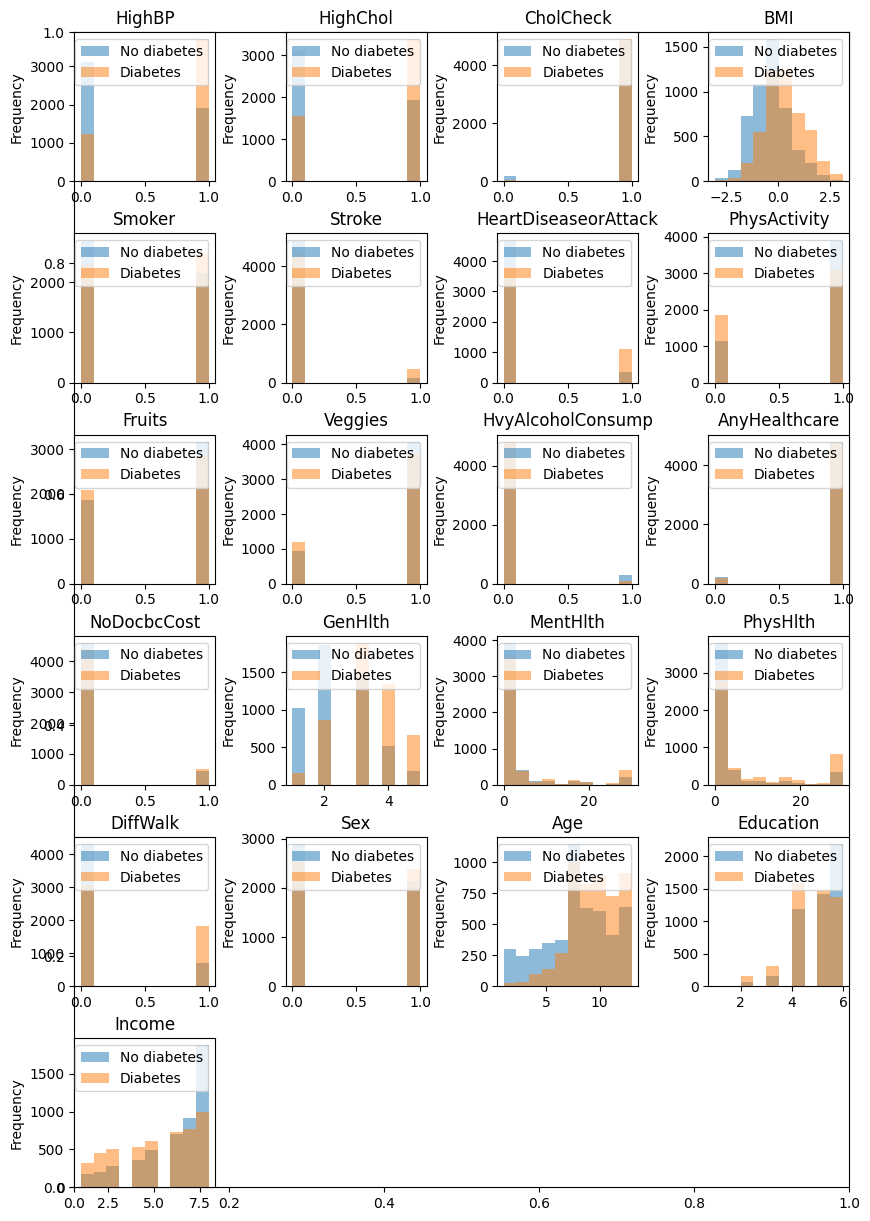

In [12]:
# Let's which features are more important i other words, which features help us to separate the data 
# in groups without supersititon.

# However, we will use sklearn to select the best k features. Fit that on whole data set and return only relevant columns. 

import matplotlib.pyplot as  plt

n = len(column_names)
cols = 4
rows = (n + cols - 1) // cols  


plt.subplots(figsize=(10, rows * 2.5))
plt.subplots_adjust(hspace=0.35,wspace=0.5)

for idx, col in enumerate(column_names):
    plt.subplot(rows, cols, idx + 1)

    df[df['Diabetes_binary'] == 0][col].plot.hist(
        bins=10, alpha=0.5, label='No diabetes'
    )

    df[df['Diabetes_binary'] == 1][col].plot.hist(
        bins=10, alpha=0.5, label='Diabetes'
    )
    plt.title(col)
    plt.legend()
plt.show()

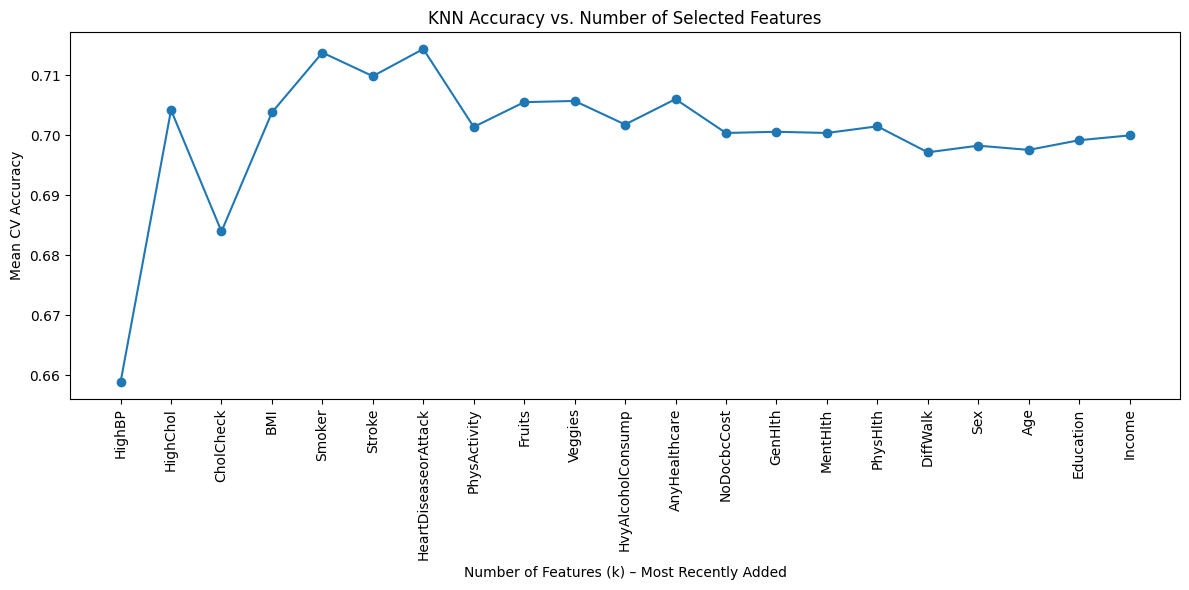

In [15]:
# Let's use SKLearn to select the best features
# We avoid to be fooled by irrelevant features

# Improvement in accuracy
# Unfortunately, we don't know before hand the relevant feature.

# Sklearn to the rescue!

from sklearn.feature_selection import mutual_info_classif # Calculate the mutual information between each feature and the target
from sklearn.feature_selection import SelectKBest # Select the k best features based on the mutual information score

# We are going to iterate over different values ok k and see which one is the best
# Array to hold mean CV accuracy for each k
scores_by_k = np.zeros(len(column_names))

for idx, feature in enumerate(column_names):
    k = idx + 1
    # Select the k best features by mutual information
    X_selected = SelectKBest(mutual_info_classif, k=k).fit_transform(X, y)

    # Evaluate with stratified CV and KNN
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(),
        X_selected,
        y,
        cv=cv,
        scoring='accuracy'
    )
    scores_by_k[idx] = np.mean(cv_scores)

# Plot: x-axis labels are the name of the last feature added for each k
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(column_names) + 1), scores_by_k, marker='o')
plt.xticks(
    ticks=range(1, len(column_names) + 1),
    labels=column_names,
    rotation=90
)
plt.xlabel('Number of Features (k) – Most Recently Added')
plt.ylabel('Mean CV Accuracy')
plt.title('KNN Accuracy vs. Number of Selected Features')
plt.tight_layout()
plt.show()

# We see that the accuracy stops increasing after the first 5 features.


### 6- Compare between base or smart KNN

In [14]:
selector_best = SelectKBest(mutual_info_classif, k=5) # Select the top t features
X_new_best = selector_best.fit_transform(X, y) 

print(len(X))
selected_features = [column_names[i] for i, keep in enumerate(selector_best.get_support()) if keep]
print("Selected features:", selected_features)

# Base KNN classifier
scores_no_weight = []
for k in range(1, 30, 2):
    knn = nb.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    cv_scores = cross_val_score(knn, X_new_best, y, cv=cv)
    scores_no_weight.append(np.mean(cv_scores))

# SMART KNN classifier
scores_weight = []
for k in range(1, 30, 2):
    knn = nb.KNeighborsClassifier(n_neighbors=k, weights='distance')
    cv_scores = cross_val_score(knn, X_new_best, y, cv=cv)
    scores_weight.append(np.mean(cv_scores))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 30, 2), scores_no_weight, 'b-o', label='No weighting')
plt.plot(range(1, 30, 2), scores_weight,   'r-s', label='Distance weighting')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Mean CV Accuracy')
plt.title('KNN accuracy for different k (using features: {} )'.format(selected_features))
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'SelectKBest' is not defined

### 7- Find best parameters


In [13]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)
clf.fit(X_new_best, y)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

NameError: name 'X_new_best' is not defined

### 8- LDA for dimensionality reduction

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit(X, y).transform(X)

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  
clf.fit(X_lda, y)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 25, 'weights': 'uniform'} Accuracy= 0.7410190984617383


### 9- Confusion matrix


              precision    recall  f1-score   support

           0       0.75      0.66      0.70      5020
           1       0.69      0.78      0.73      4919

    accuracy                           0.72      9939
   macro avg       0.72      0.72      0.72      9939
weighted avg       0.72      0.72      0.72      9939



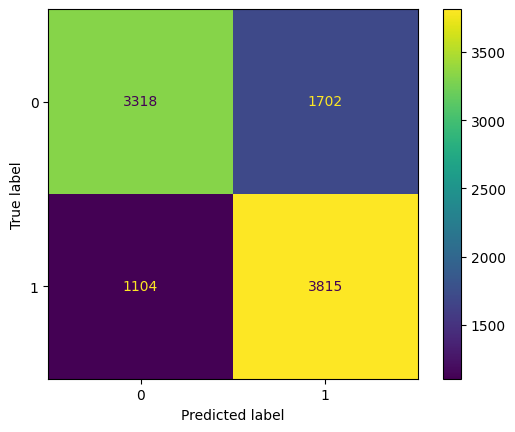

In [ ]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

knn = nb.KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], weights=clf.best_params_['weights'])

predicted = cross_val_predict( #Estudia varianza de los datos partiendo. 
    knn,
    X = X,
    y = y, 
    cv = cv
)

print(classification_report(y, predicted))  
ConfusionMatrixDisplay(confusion_matrix(y, predicted)).plot()

### 9 - Maximize recall


Fitting 20 folds for each of 180 candidates, totalling 3600 fits
Best Params= {'metric': 'manhattan', 'n_neighbors': 27, 'p': 1, 'weights': 'uniform'} Recall= 0.7804
              precision    recall  f1-score   support

           0       0.76      0.68      0.71      5020
           1       0.70      0.78      0.74      4919

    accuracy                           0.73      9939
   macro avg       0.73      0.73      0.73      9939
weighted avg       0.73      0.73      0.73      9939



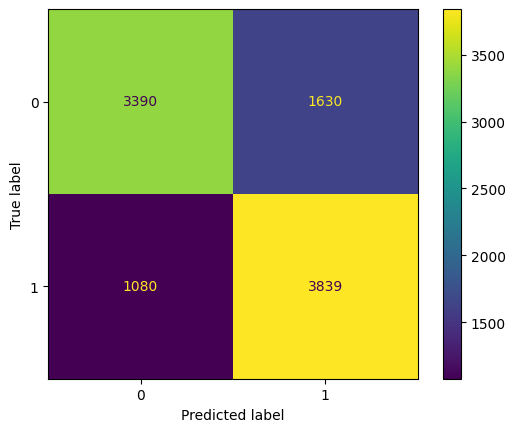

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score


recall_scorer = make_scorer(recall_score, average='binary', pos_label=1) 

# Ampliar la búsqueda de parámetros
params = {
    'n_neighbors': list(range(1, 30, 2)),
    'weights': ('distance', 'uniform'),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}


knc = nb.KNeighborsClassifier()
clf = GridSearchCV(
    knc, 
    params, 
    cv=cv,
    scoring=recall_scorer,
    verbose=1
)

clf.fit(X, y)
print(f"Best Params= {clf.best_params_} Recall= {clf.best_score_:.4f}")

knn_recall = nb.KNeighborsClassifier(**clf.best_params_)

predicted = cross_val_predict(
    knn_recall,
    X=X,
    y=y,
    cv=cv
)

print(classification_report(y, predicted))
ConfusionMatrixDisplay(confusion_matrix(y, predicted)).plot()

### 10- Make manadatory recall = 1 with threshold


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

# Use the best KNN model from GridSearchCV
best_knn = nb.KNeighborsClassifier()

print("="*80)
print("DECISION THRESHOLD OPTIMIZATION ANALYSIS TO MAXIMIZE RECALL")
print("="*80)
print("\nRunning cross-validation to obtain prediction probabilities...")

# Get prediction probabilities through cross-validation
y_proba = cross_val_predict(
    best_knn, 
    X=X,
    y=y,
    cv=cv,
    method='predict_proba'
)

# Probability for class 1 (has diabetes)
y_scores = y_proba[:, 1]

print(f"Processing results for {len(y)} samples...")

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, y_scores)

# Calculate area under precision-recall curve
pr_auc = auc(recall, precision)

print("\n"+"="*80)
print("CHART 1: PRECISION-RECALL CURVE")
print("="*80)
print("This curve shows the relationship between precision and recall for different thresholds.")
print(f"The area under the curve (PR-AUC) is {pr_auc:.3f}.")
print("A curve closer to the upper right corner indicates better performance.")
print("="*80)

# Plot precision-recall curve using PrecisionRecallDisplay
plt.figure(figsize=(10, 6))
display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc)
display.plot()
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
plt.grid(True)
plt.show()

print("\n"+"="*80)
print("CHART 2: THRESHOLD vs PRECISION-RECALL")
print("="*80)
print("This chart shows how precision and recall change as the decision threshold varies.")
print("- Blue line (--): Precision at different thresholds")
print("- Green line (-): Recall at different thresholds")
print("The optimal threshold for maximizing recall is where the green line reaches its maximum value.")
print("="*80)

# Plot threshold vs precision-recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall as a Function of Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the smallest threshold that produces recall = 1
recall_one_indices = np.where(recall[:-1] == 1.0)[0]
if len(recall_one_indices) > 0:
    # If there are thresholds with recall=1, take the largest one (for better precision)
    max_recall_one_idx = recall_one_indices[-1]
    optimal_threshold = thresholds[max_recall_one_idx]
    precision_at_recall_one = precision[max_recall_one_idx]
    print(f"\nOptimal threshold for recall=1: {optimal_threshold:.4f}")
    print(f"Precision with recall=1: {precision_at_recall_one:.4f}")
else:
    # If no threshold gives recall=1, take the threshold with the highest recall
    max_recall_idx = np.argmax(recall[:-1])
    optimal_threshold = thresholds[max_recall_idx]
    max_recall = recall[max_recall_idx]
    precision_at_max_recall = precision[max_recall_idx]
    print(f"\nCannot achieve recall=1 exactly. Threshold for maximum recall: {optimal_threshold:.4f}")
    print(f"Maximum recall: {max_recall:.4f}")
    print(f"Precision at maximum recall: {precision_at_max_recall:.4f}")

# Make predictions using the optimal threshold
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

print("\n"+"="*80)
print("RESULTS WITH OPTIMIZED THRESHOLD")
print("="*80)
print("Below is the performance of the model with the threshold optimized to maximize recall.")
print(f"Selected threshold: {optimal_threshold:.4f}")
print("="*80)

# Show confusion matrix and classification report
print("\nClassification Report with Optimal Threshold:")
# Use zero_division=0 to avoid warnings
print(classification_report(y, y_pred_optimal, zero_division=0))

print("\n"+"="*80)
print("CHART 3: CONFUSION MATRIX WITH OPTIMAL THRESHOLD")
print("="*80)
print(f"This matrix shows the classification results using the optimal threshold of {optimal_threshold:.4f}.")
print("- True Negatives (top left): Negative cases correctly classified")
print("- False Positives (top right): Negative cases incorrectly classified as positive")
print("- False Negatives (bottom left): Positive cases incorrectly classified as negative")
print("- True Positives (bottom right): Positive cases correctly classified")
print("="*80)

ConfusionMatrixDisplay(confusion_matrix(y, y_pred_optimal)).plot(values_format='d')
plt.title(f"Confusion Matrix (Threshold = {optimal_threshold:.4f})")
plt.show()

# Compare with default threshold (0.5)
y_pred_default = (y_scores >= 0.5).astype(int)

print("\n"+"="*80)
print("RESULTS WITH DEFAULT THRESHOLD (0.5)")
print("="*80)
print("Below is the performance of the model with the default threshold of 0.5")
print("="*80)

print("\nClassification Report with Default Threshold (0.5):")
# Use zero_division=0 to avoid warnings
print(classification_report(y, y_pred_default, zero_division=0))

print("\n"+"="*80)
print("CHART 4: CONFUSION MATRIX WITH DEFAULT THRESHOLD (0.5)")
print("="*80)
print("This matrix shows the classification results using the standard threshold of 0.5.")
print("Useful for comparison with the matrix obtained using the optimized threshold.")
print("="*80)

ConfusionMatrixDisplay(confusion_matrix(y, y_pred_default)).plot(values_format='d')
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

# Calculate and plot ROC curve
fpr, tpr, roc_thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)

print("\n"+"="*80)
print("CHART 5: ROC CURVE")
print("="*80)
print(f"The ROC curve shows the classifier performance at different decision thresholds.")
print(f"The area under the curve (AUC) is {roc_auc:.3f}. A value of 1.0 indicates perfect classification.")
print("The X-axis represents the False Positive Rate and the Y-axis represents the True Positive Rate (recall).")
print("A curve closer to the upper left corner indicates better performance.")
print("="*80)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Mark the point for the optimal threshold on the ROC curve
optimal_idx = np.argmin(np.abs(roc_thresholds - optimal_threshold))

print("\n"+"="*80)
print("CHART 6: ROC CURVE WITH OPTIMAL THRESHOLD MARKED")
print("="*80)
print(f"This ROC curve has the point corresponding to the optimal threshold ({optimal_threshold:.4f}) marked.")
print(f"At this point, the model achieves a recall of {recall[np.where(thresholds == optimal_threshold)[0][0] if optimal_threshold in thresholds else -1]:.4f}")
print("This point shows the balance between false positives and true positives with the selected threshold.")
print("="*80)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
         label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve with Optimal Threshold Point')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Final summary
print("\n"+"="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Best threshold to maximize recall: {optimal_threshold:.4f}")
print(f"Recall with optimal threshold: {recall_score(y, y_pred_optimal, zero_division=0):.4f}")
print(f"Precision with optimal threshold: {precision_at_recall_one if len(recall_one_indices) > 0 else precision_at_max_recall:.4f}")
print(f"ROC curve AUC: {roc_auc:.4f}")
print(f"Precision-Recall curve AUC: {pr_auc:.4f}")
print("="*80)

NameError: name 'nb' is not defined